# Data Cleaning

## Outline
0. Load and join dataframes
1. Handle missing values
   - Identify columns with missing data
   - Decide on appropriate strategies for each column
   - Impute or handle missing values as needed
2. Convert data types
   - Change 'start_date' to datetime format
   - Convert 'home_line_scores' and 'away_line_scores' to usable format
3. Handle outliers
   - Check for and address unrealistic values in numerical columns
4. Create derived features
   - Calculate point difference
   - Generate 'winner' column
   - Create time-based features from 'start_date'
5. Review and validate cleaned dataset

## Load Packages & Data

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import sqlite3
import pandas as pd

# Add the project root to the Python path
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data.cleaning import (
    merge_and_clean_dataframes,
    clean_dataframe,
    generate_and_save_team_pairs,
    deduplicate_dataframes
)
from src.visualization.distribution_plots import (
    analyze_distribution,
    visualize_null_values,
    plot_mean_over_time,
    plot_null_frequency_by_season,
    plot_zero_values_by_year
)

In [2]:
def load_data_from_db(db_path):
    conn = sqlite3.connect(db_path)
    
    advanced_stats_df = pd.read_sql("SELECT * FROM advanced_team_game_stats", conn)
    betting_df = pd.read_sql("SELECT * FROM betting_lines", conn)
    elo_df = pd.read_sql("SELECT * FROM elo_ratings", conn)
    fpi_df = pd.read_sql("SELECT * FROM fpi_ratings", conn)
    games_df = pd.read_sql("SELECT * FROM games", conn)
    probabilities_df = pd.read_sql("SELECT * FROM pregame_win_probabilities", conn)
    sp_df = pd.read_sql("SELECT * FROM sp_ratings", conn)
    srs_df = pd.read_sql("SELECT * FROM srs_ratings", conn)
    team_stats_df = pd.read_sql("SELECT * FROM team_game_stats", conn)
    recruiting_df = pd.read_sql("SELECT * FROM team_recruiting", conn)
    team_talent_df = pd.read_sql("SELECT * FROM team_talent", conn)
    
    conn.close()
    
    return (
        advanced_stats_df,
        betting_df,
        elo_df,
        fpi_df,
        games_df,
        probabilities_df,
        sp_df,
        srs_df,
        team_stats_df,
        recruiting_df,
        team_talent_df
    )

# Usage
db_path = '../data/02_interim/college_football.db'

(advanced_stats_df, betting_df, elo_df,
 fpi_df, games_df, probabilities_df,
 sp_df, srs_df, team_stats_df,
 recruiting_df, team_talent_df) = load_data_from_db(db_path)

In [3]:
def analyze_missing_games(games_df, stats_df, stats_df_name, column_name):
    # Count number of rows in games_df where id does not exist in stats_df.id
    missing_games = games_df[~games_df['id'].isin(stats_df[column_name])]
    missing_count = len(missing_games)

    # Calculate the percentage
    total_games = len(games_df)
    missing_percentage = (missing_count / total_games) * 100

    print(f"Number of games missing from {stats_df_name}: {missing_count}")
    print(f"Percentage of games missing: {missing_percentage:.2f}%")

    # Optional: Display some information about the missing games
    print("\nSample of missing games:")
    print(missing_games[['id', 'season', 'week', 'home_team', 'away_team']].head())

In [4]:
analyze_missing_games(games_df, team_stats_df, "team_stats_df", "id")

Number of games missing from team_stats_df: 1327
Percentage of games missing: 11.82%

Sample of missing games:
          id  season  week   home_team         away_team
0  212420008    2001     2    Arkansas              UNLV
1  212420238    2001     2  Vanderbilt  Middle Tennessee
2  212440096    2001     2    Kentucky        Louisville
3  212440061    2001     2     Georgia    Arkansas State
4  212442633    2001     2   Tennessee          Syracuse


In [5]:
analyze_missing_games(games_df, advanced_stats_df, "advanced_stats_df", "game_id")

Number of games missing from advanced_stats_df: 753
Percentage of games missing: 6.71%

Sample of missing games:
       id  season  week          home_team         away_team
43  63799    2001     9           Ole Miss  Middle Tennessee
44  63812    2001     9     South Carolina        Vanderbilt
45  63794    2001     9  Mississippi State               LSU
46  63786    2001     9            Georgia          Kentucky
47  63776    2001     9             Auburn    Louisiana Tech


In [6]:
def check_missing_game_team_pairs(advanced_stats_df, games_df):
    # Create sets of game-team pairs
    advanced_pairs = set(zip(advanced_stats_df['game_id'], advanced_stats_df['team']))
    home_pairs = set(zip(games_df['id'], games_df['home_team']))
    away_pairs = set(zip(games_df['id'], games_df['away_team']))
    
    # Combine home and away pairs
    all_game_pairs = home_pairs.union(away_pairs)
    
    # Find missing pairs
    missing_pairs = advanced_pairs - all_game_pairs
    
    # Count missing pairs
    missing_count = len(missing_pairs)
    
    # Calculate percentage
    total_pairs = len(advanced_pairs)
    missing_percentage = (missing_count / total_pairs) * 100
    
    print(f"Number of missing game-team pairs: {missing_count}")
    print(f"Percentage of missing pairs: {missing_percentage:.2f}%")
    
    # Display some examples of missing pairs
    print("\nSample of missing pairs (game_id, team):")
    for pair in list(missing_pairs)[:5]:
        print(pair)

# Usage
check_missing_game_team_pairs(advanced_stats_df, games_df)

Number of missing game-team pairs: 17966
Percentage of missing pairs: 48.18%

Sample of missing pairs (game_id, team):
(303242572, 'Houston')
(401415627, 'Tulsa')
(401249884, 'Eastern Michigan')
(400787412, 'Howard')
(401019476, 'Tulsa')


In [7]:
def check_missing_game_team_pairs(advanced_stats_df, games_df):
    # Create copies to avoid modifying the original DataFrames
    adv_stats_copy = advanced_stats_df.copy()
    games_df_copy = games_df.copy()

    # Standardize team names to uppercase and strip whitespace in the copies
    adv_stats_copy['team'] = adv_stats_copy['team'].str.upper().str.strip()
    games_df_copy['home_team'] = games_df_copy['home_team'].str.upper().str.strip()
    games_df_copy['away_team'] = games_df_copy['away_team'].str.upper().str.strip()

    # Ensure game_id columns are of the same data type in the copies
    adv_stats_copy['game_id'] = adv_stats_copy['game_id'].astype(str)
    games_df_copy['id'] = games_df_copy['id'].astype(str)

    # Create sets of game-team pairs from the copies
    advanced_pairs = set(zip(adv_stats_copy['game_id'], adv_stats_copy['team']))
    home_pairs = set(zip(games_df_copy['id'], games_df_copy['home_team']))
    away_pairs = set(zip(games_df_copy['id'], games_df_copy['away_team']))

    # Combine home and away pairs
    all_game_pairs = home_pairs.union(away_pairs)

    # Find missing pairs
    missing_pairs = all_game_pairs - advanced_pairs

    # Count missing pairs
    missing_count = len(missing_pairs)

    # Calculate percentage
    total_pairs = len(all_game_pairs)
    missing_percentage = (missing_count / total_pairs) * 100 if total_pairs else 0

    print(f"Number of missing game-team pairs: {missing_count}")
    print(f"Percentage of missing pairs: {missing_percentage:.2f}%")

    # Display some examples of missing pairs
    if missing_pairs:
        print("\nSample of missing pairs (game_id, team):")
        for pair in list(missing_pairs)[:5]:
            print(pair)
    else:
        print("\nNo missing game-team pairs found.")

check_missing_game_team_pairs(advanced_stats_df, games_df)


Number of missing game-team pairs: 1424
Percentage of missing pairs: 6.86%

Sample of missing pairs (game_id, team):
('400868922', 'ARIZONA')
('253090052', 'FLORIDA STATE')
('401635608', 'NC STATE')
('262590265', 'WASHINGTON STATE')
('222500142', 'BALL STATE')


## Cleaning summary

1. Build Transformed Teams db

-   Goal is to build on team_stats_df
-   Checking for duplicates:
    -   found in games_df, team_stats_df, and team_talent_df
    -   **Drop duplicates**
-   **Drop duplicates in team_game_stats**
    -   Drop points column
-   **LEFT JOIN advanced_team_game_stats**
    -   on as.game_id == tgs.id AND as.team == tgs.school
    -   drop season, week, and team columns, keep the rest
-   **LEFT JOIN betting_lines** --> needs to join on both matches
    -   on id
    -   *do we switch sign based on home_away?**
    -   average(line_spread) as avg_line_spread --> this will ignore nulls and return null if null?
    -   average(line_spread_open) as avg_line_spread_open
    -   average(line_over_under) as avg_line_over_under
    -   average(line_over_under_open) as avg_line_over_under_open
    -   average(line_home_moneyline) as avg_line_home_moneyline
    -   average(line_away_moneyline) as avg_line_away_moneyline
-   **LEFT JOIN games**
    -   on id = id
    -   season, week, season_type, start_date, completed
    -   neutral_site, conference_game, attendance, venue_id
    -   venue,
    -   *make these conditional on home_away, team vs opponent*
        -   home_points, home_line_scores
        -   home_pregame_elo, home_postgame_elo, 
        -   away_points, away_line_scores
        -   away_pregame_elo, home_postgame_elo
        -   home_id, away_id
    -   excitement_index
-   **LEFT JOIN elo_ratings**
    -   on er.year = games.season AND er.team = tgs.school(?)
    -   elo as elo_year
-   **fpi_ratings appear to be updated live... so not using**
    -   Same with sp_ratings
    -   same with srs_ratings


In [8]:
from src.data.create_transformed_teams import create_transformed_teams_db

source_db_path = '../data/02_interim/college_football.db'
target_db_path = '../data/02_interim/transformed_teams.db'

create_transformed_teams_db(source_db_path, target_db_path)

Transformed teams data has been written to ../data/02_interim/transformed_teams.db


In [9]:
from src.data.create_transformed_teams import load_transformed_teams_df

# Assuming you're in the project root directory
target_db_path = '../data/02_interim/transformed_teams.db'
transformed_teams_df = load_transformed_teams_df(target_db_path)

# Now you can work with the transformed_teams_df
print(transformed_teams_df.shape)

(20750, 138)


In [10]:
def count_duplicates(df):
    """
    Count the number of duplicated rows in a DataFrame.
    
    Args:
    df (pandas.DataFrame): The DataFrame to check for duplicates.
    
    Returns:
    int: The number of duplicated rows.
    """
    num_duplicates = df.duplicated().sum()
    total_rows = len(df)
    duplicate_percentage = (num_duplicates / total_rows) * 100
    
    if num_duplicates > 0:
        print(f"Total rows: {total_rows}")
        print(f"Number of duplicated rows: {num_duplicates}")
        print(f"Percentage of duplicated rows: {duplicate_percentage:.2f}%")
    else:
        print("No duplicates found.")
    
    return num_duplicates

print("Checking for duplicates in advanced_stats_df:")
count_duplicates(advanced_stats_df)

print("\nChecking for duplicates in betting_df:")
count_duplicates(betting_df)

print("\nChecking for duplicates in elo_df:")
count_duplicates(elo_df)

print("\nChecking for duplicates in fpi_df:")
count_duplicates(fpi_df)

print("\nChecking for duplicates in games_df:")
count_duplicates(games_df)

print("\nChecking for duplicates in probabilities_df:")
count_duplicates(probabilities_df)

print("\nChecking for duplicates in sp_df:")
count_duplicates(sp_df)

print("\nChecking for duplicates in srs_df:")
count_duplicates(srs_df)

print("\nChecking for duplicates in team_stats_df:")
count_duplicates(team_stats_df)

print("\nChecking for duplicates in recruiting_df:")
count_duplicates(recruiting_df)

print("\nChecking for duplicates in team_talent_df:")
count_duplicates(team_talent_df)

print("\nChecking for duplicates in transformed_teams_df:")
count_duplicates(transformed_teams_df)


Checking for duplicates in advanced_stats_df:
No duplicates found.

Checking for duplicates in betting_df:
No duplicates found.

Checking for duplicates in elo_df:
No duplicates found.

Checking for duplicates in fpi_df:
No duplicates found.

Checking for duplicates in games_df:
Total rows: 11230
Number of duplicated rows: 855
Percentage of duplicated rows: 7.61%

Checking for duplicates in probabilities_df:
No duplicates found.

Checking for duplicates in sp_df:
No duplicates found.

Checking for duplicates in srs_df:
No duplicates found.

Checking for duplicates in team_stats_df:
No duplicates found.

Checking for duplicates in recruiting_df:
Total rows: 5307
Number of duplicated rows: 1273
Percentage of duplicated rows: 23.99%

Checking for duplicates in team_talent_df:
Total rows: 2144
Number of duplicated rows: 3
Percentage of duplicated rows: 0.14%

Checking for duplicates in transformed_teams_df:
No duplicates found.


np.int64(0)

## Check for Duplicates

In [11]:
# Check for duplicate 'id' and 'team' combinations
duplicate_id_team = transformed_teams_df.duplicated(subset=['id', 'team'])
num_duplicates = duplicate_id_team.sum()
total_rows = len(transformed_teams_df)
duplicate_percentage = (num_duplicates / total_rows) * 100

print(f"Number of duplicate 'id' and 'team' combinations: {num_duplicates}")
print(f"Percentage of duplicate 'id' and 'team' combinations: {duplicate_percentage:.2f}%")


Number of duplicate 'id' and 'team' combinations: 0
Percentage of duplicate 'id' and 'team' combinations: 0.00%


## Data Types

In [12]:
# Batch print data types for better readability
print("Data types of transformed_teams_df:")
for column, dtype in transformed_teams_df.dtypes.items():
    print(f"{column:<30} {dtype}")

Data types of transformed_teams_df:
id                             int64
year                           int64
week                           int64
season_type                    object
start_date                     object
completed                      int64
neutral_site                   int64
conference_game                object
attendance                     float64
venue_id                       float64
venue                          object
team                           object
team_id                        int64
opponent                       object
opponent_id                    int64
team_conference                object
opponent_conference            object
team_division                  object
opponent_division              object
team_points                    float64
opponent_points                float64
team_line_scores               object
opponent_line_scores           object
team_post_win_prob             float64
opponent_post_win_prob         float64
excitement_inde

## Handle Missing Values

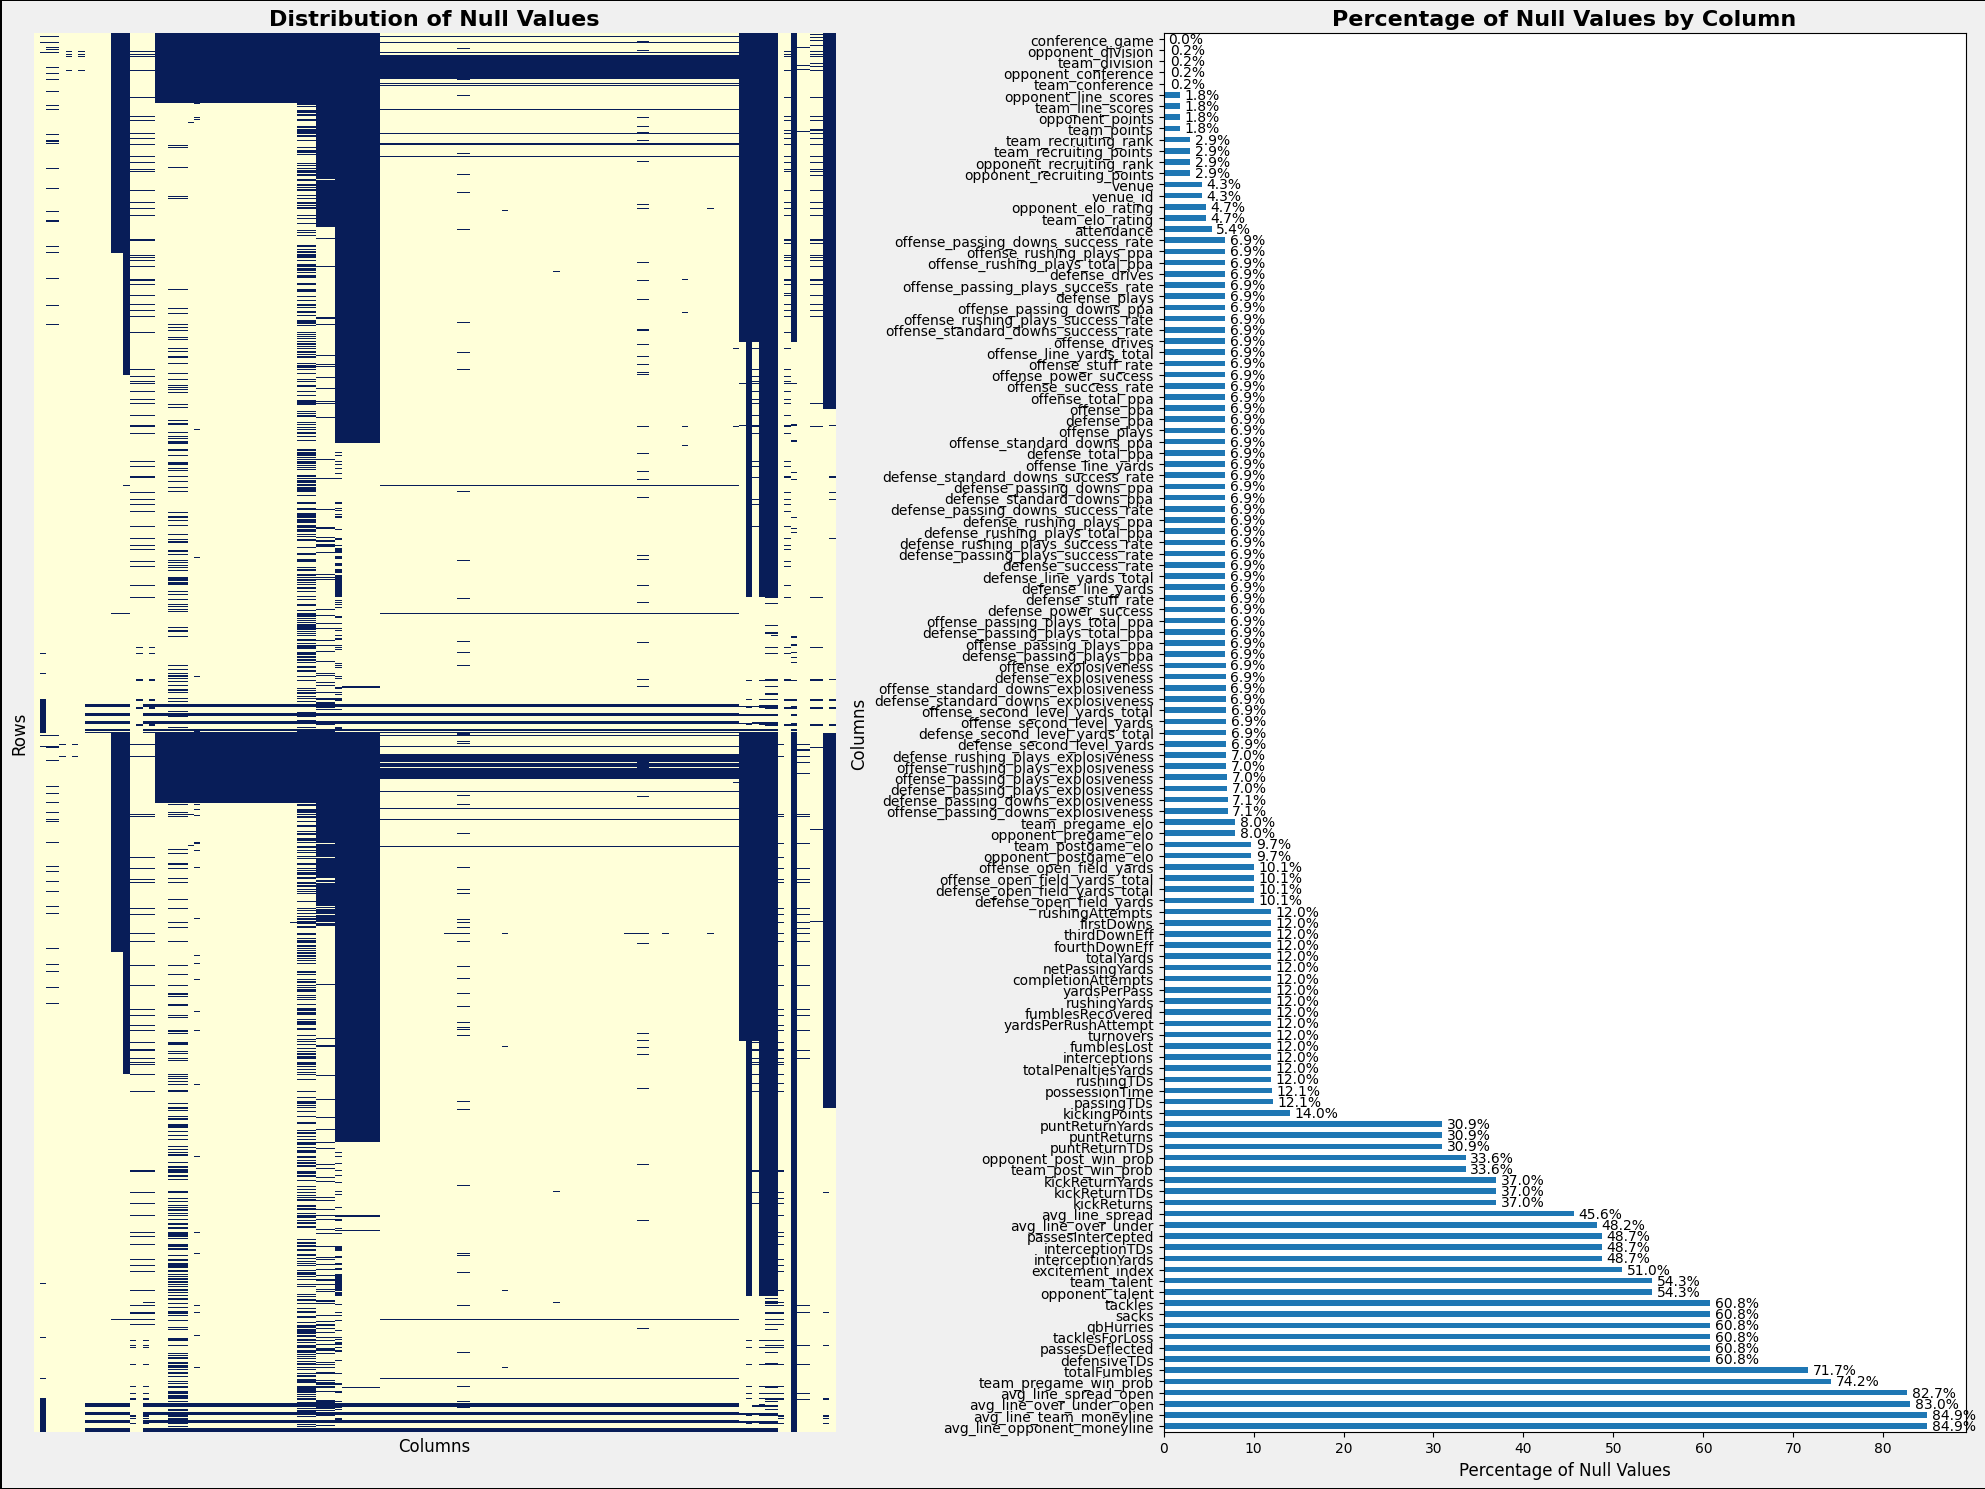

Columns with null values (sorted by percentage, descending):
avg_line_opponent_moneyline: 17619 null values (84.91%)
avg_line_team_moneyline: 17619 null values (84.91%)
avg_line_over_under_open: 17218 null values (82.98%)
avg_line_spread_open: 17152 null values (82.66%)
team_pregame_win_prob: 15403 null values (74.23%)
totalFumbles: 14874 null values (71.68%)
defensiveTDs: 12611 null values (60.78%)
passesDeflected: 12611 null values (60.78%)
tacklesForLoss: 12611 null values (60.78%)
qbHurries: 12611 null values (60.78%)
sacks: 12611 null values (60.78%)
tackles: 12611 null values (60.78%)
opponent_talent: 11277 null values (54.35%)
team_talent: 11277 null values (54.35%)
excitement_index: 10584 null values (51.01%)
interceptionYards: 10104 null values (48.69%)
interceptionTDs: 10104 null values (48.69%)
passesIntercepted: 10104 null values (48.69%)
avg_line_over_under: 9998 null values (48.18%)
avg_line_spread: 9464 null values (45.61%)
kickReturns: 7676 null values (36.99%)
kickRetu

In [12]:
visualize_null_values(transformed_teams_df)

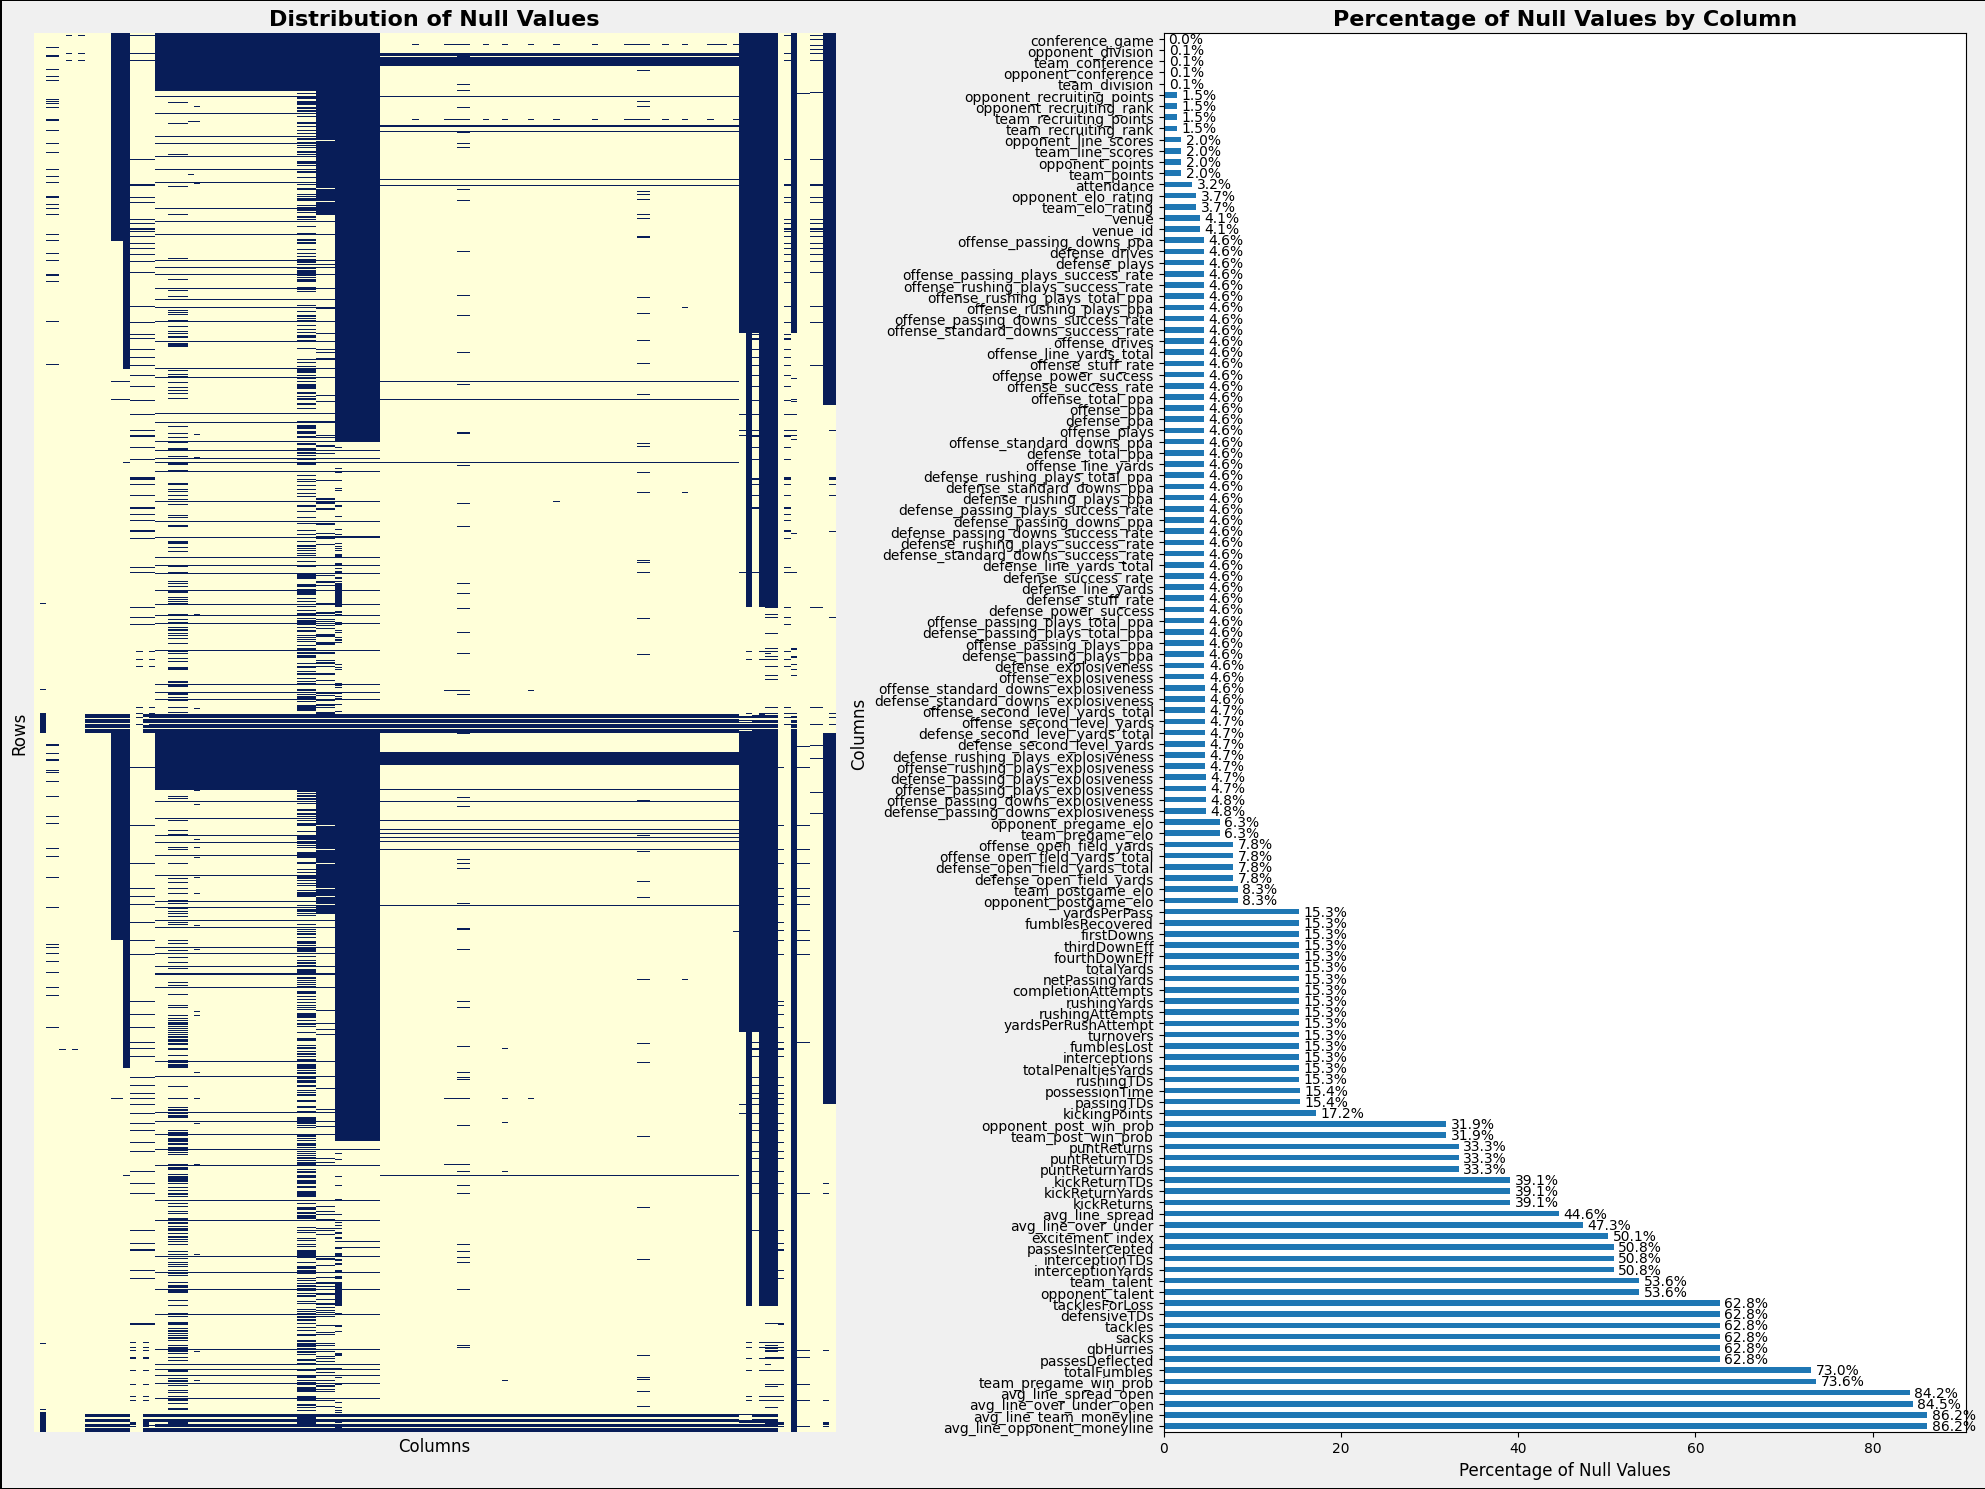

Columns with null values (sorted by percentage, descending):
avg_line_opponent_moneyline: 132534 null values (86.19%)
avg_line_team_moneyline: 132534 null values (86.19%)
avg_line_over_under_open: 130010 null values (84.54%)
avg_line_spread_open: 129482 null values (84.20%)
team_pregame_win_prob: 113216 null values (73.62%)
totalFumbles: 112322 null values (73.04%)
passesDeflected: 96514 null values (62.76%)
qbHurries: 96514 null values (62.76%)
sacks: 96514 null values (62.76%)
tackles: 96514 null values (62.76%)
defensiveTDs: 96514 null values (62.76%)
tacklesForLoss: 96514 null values (62.76%)
opponent_talent: 82490 null values (53.64%)
team_talent: 82490 null values (53.64%)
interceptionYards: 78141 null values (50.81%)
interceptionTDs: 78141 null values (50.81%)
passesIntercepted: 78141 null values (50.81%)
excitement_index: 77118 null values (50.15%)
avg_line_over_under: 72746 null values (47.31%)
avg_line_spread: 68658 null values (44.65%)
kickReturns: 60119 null values (39.09%)

In [4]:
visualize_null_values(transformed_teams_df)

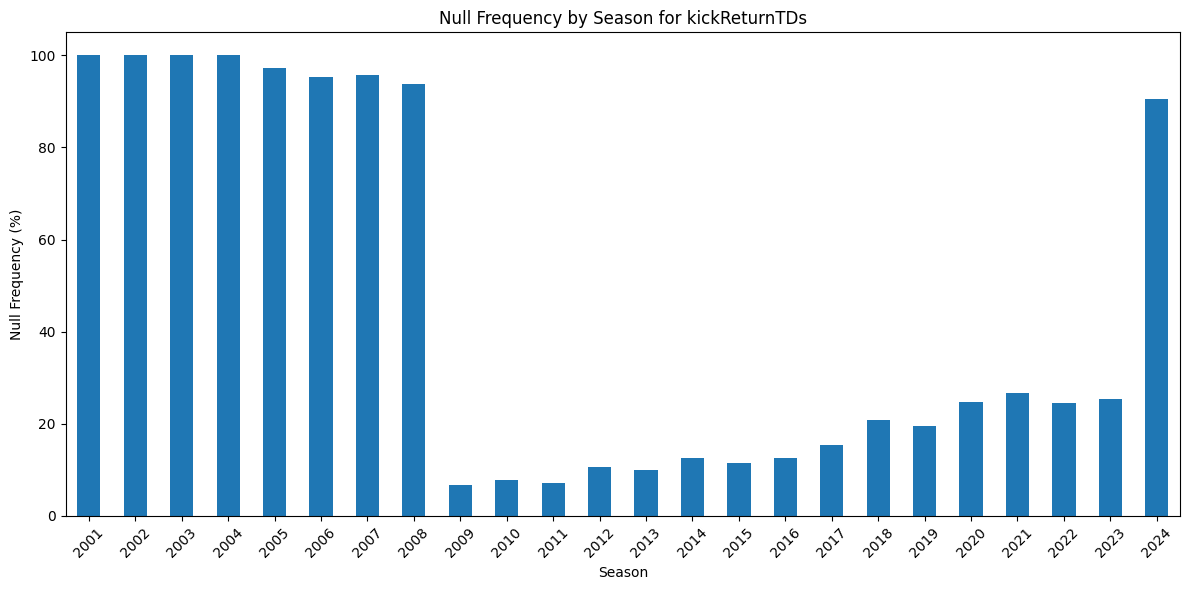

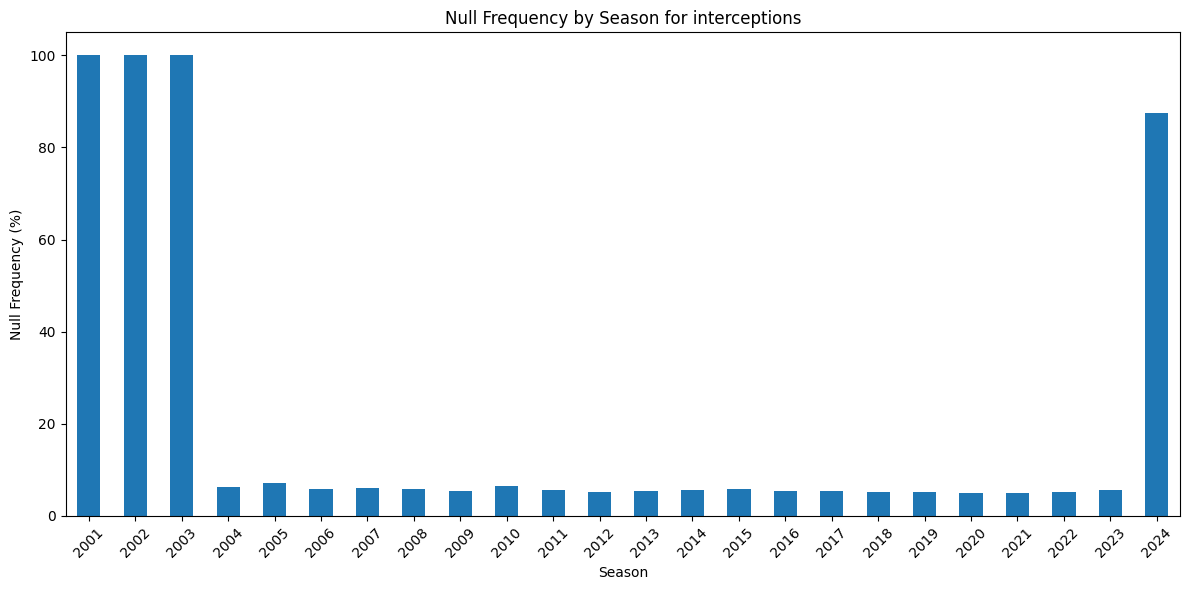

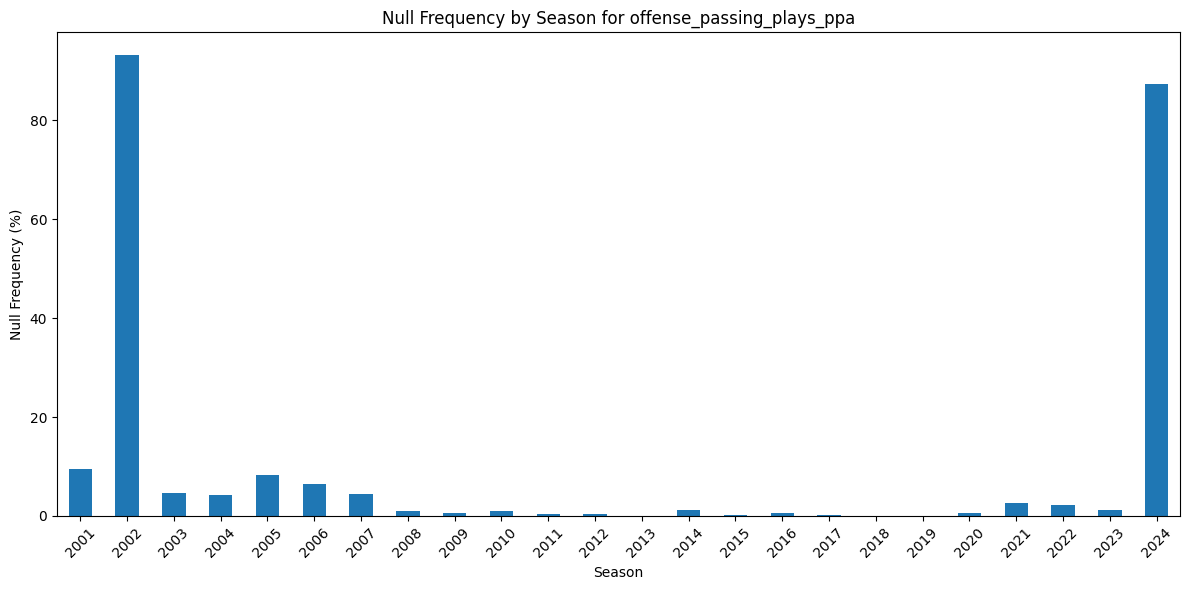

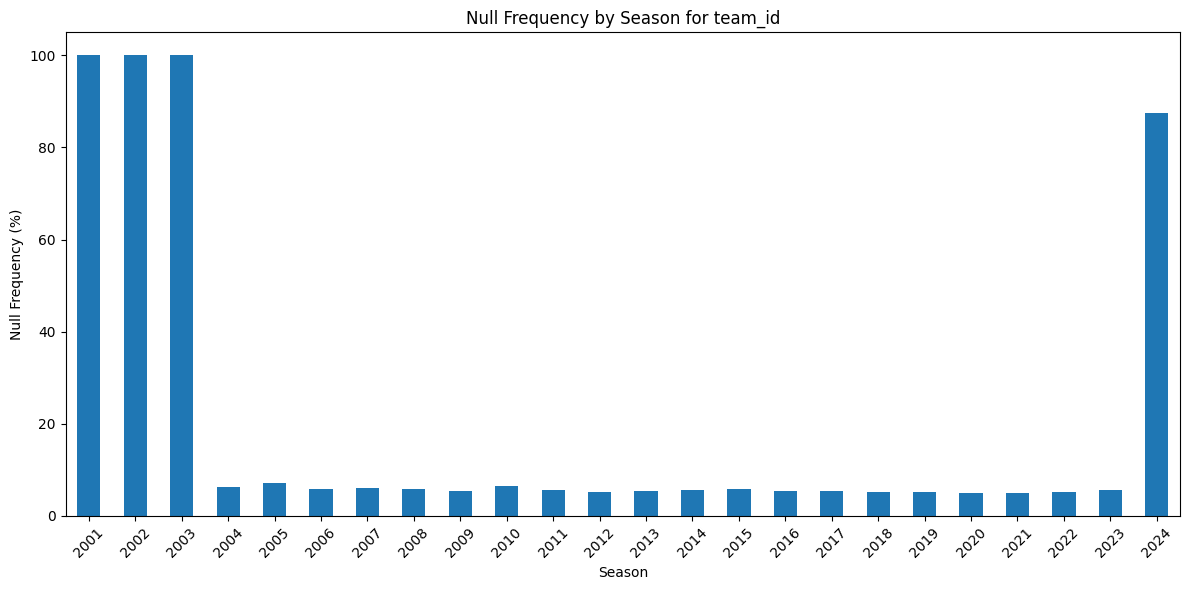

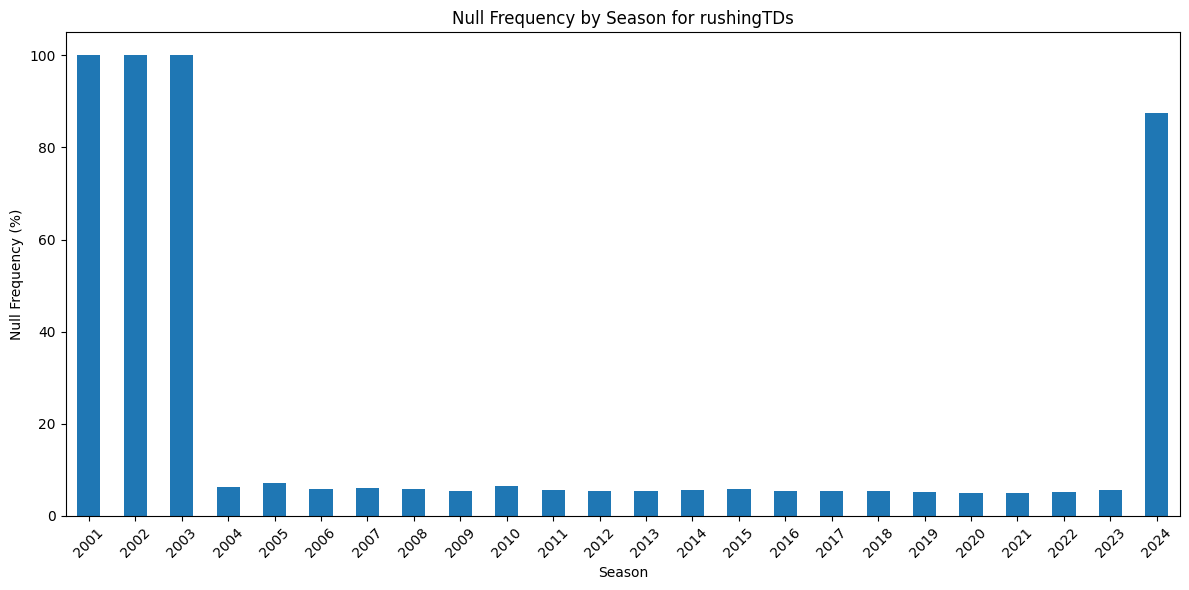

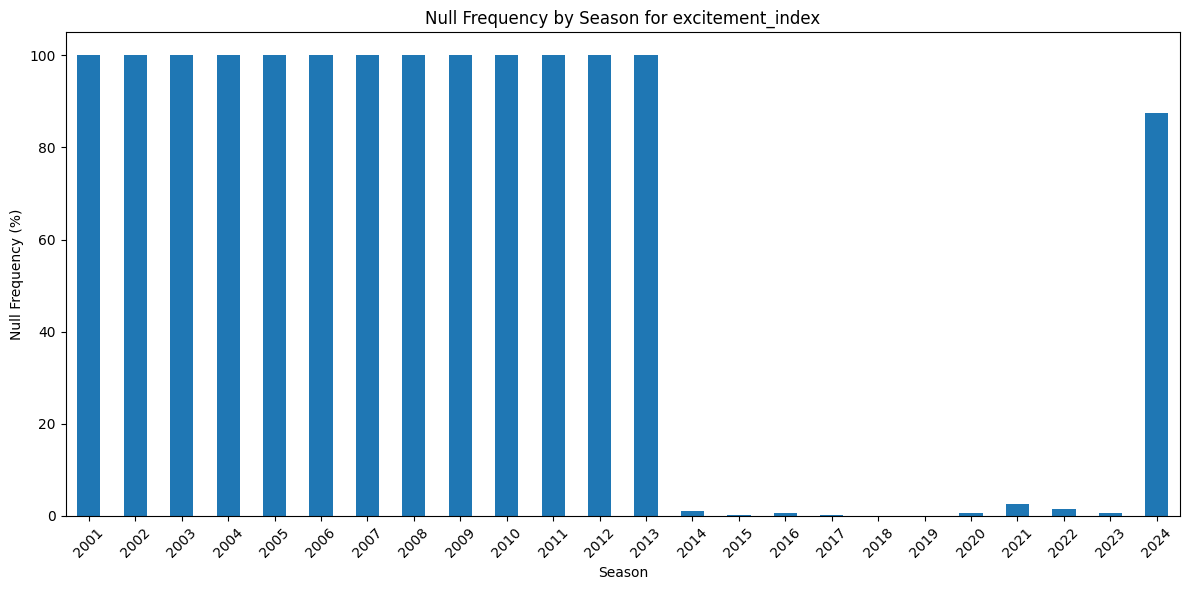

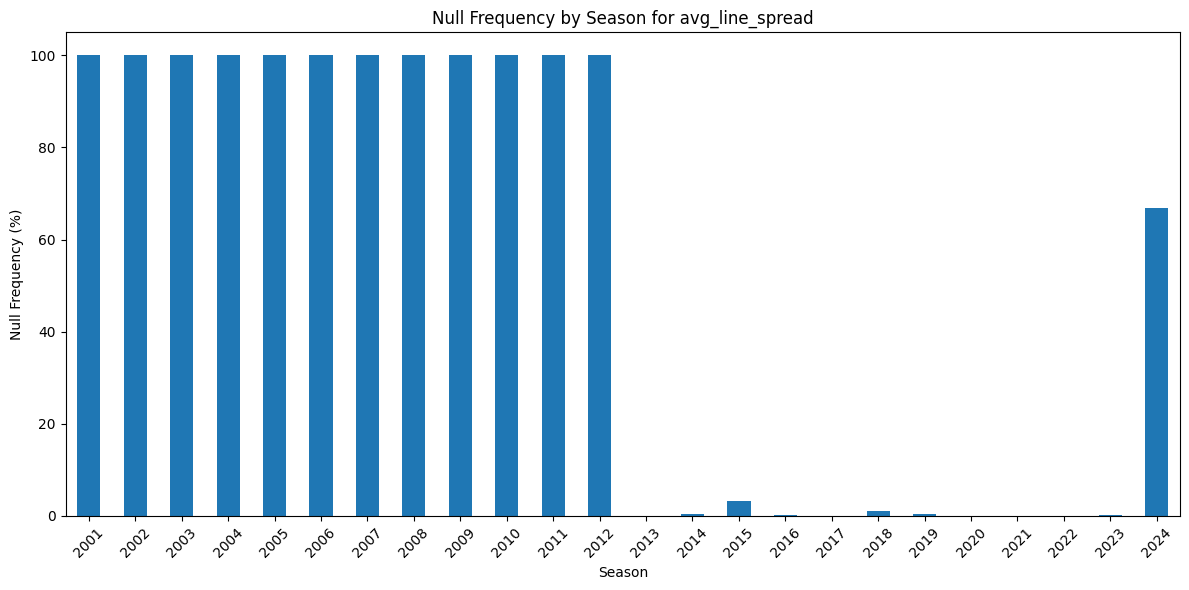

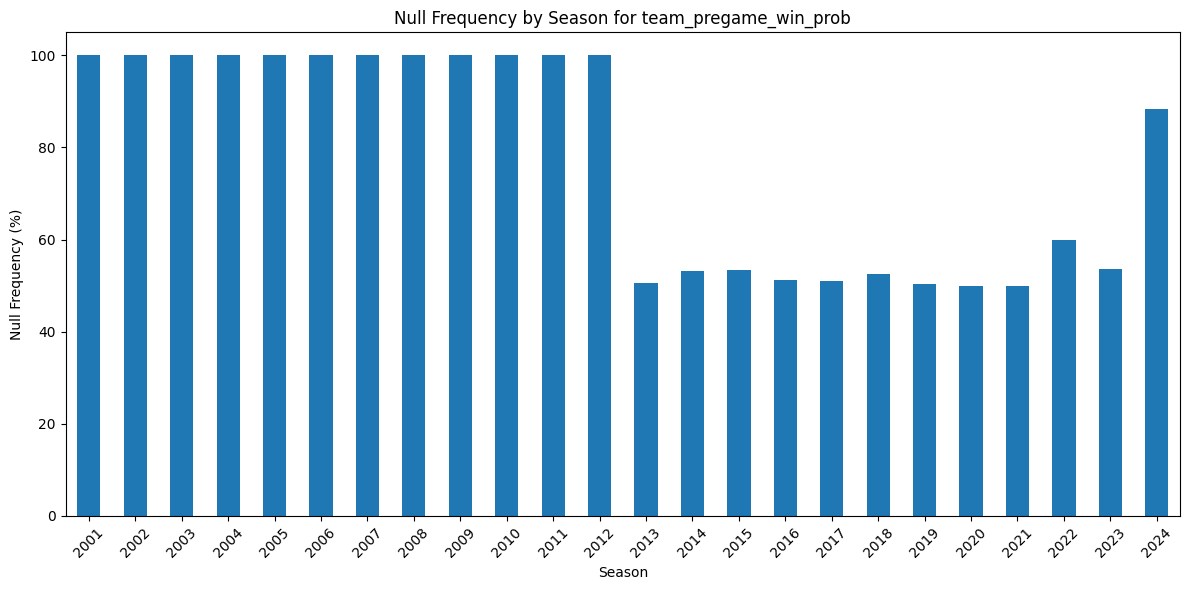

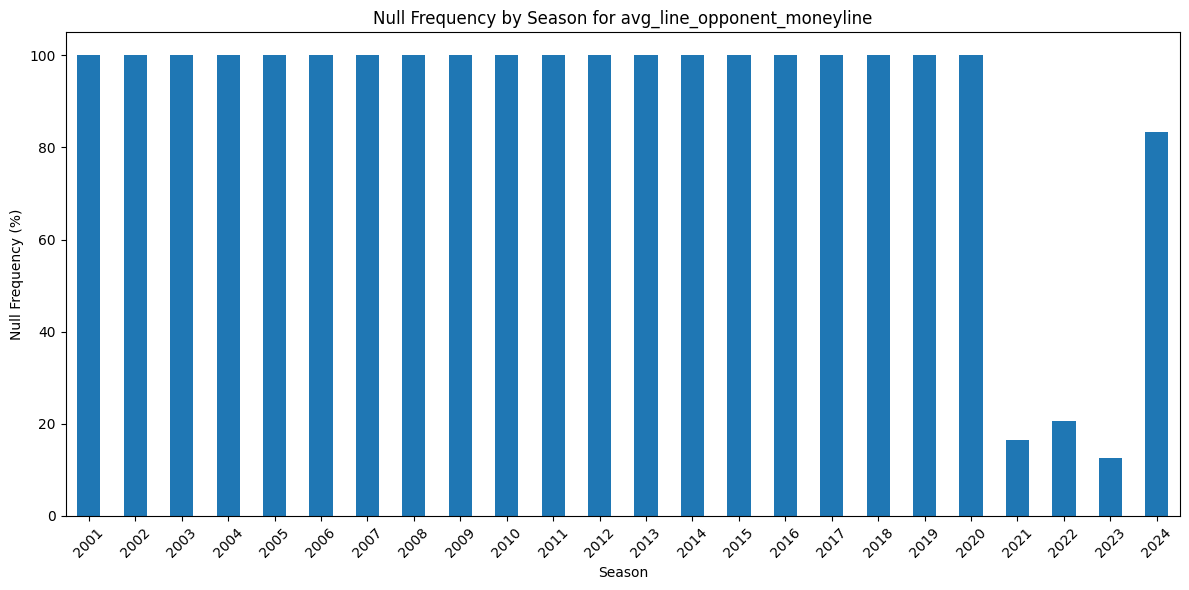

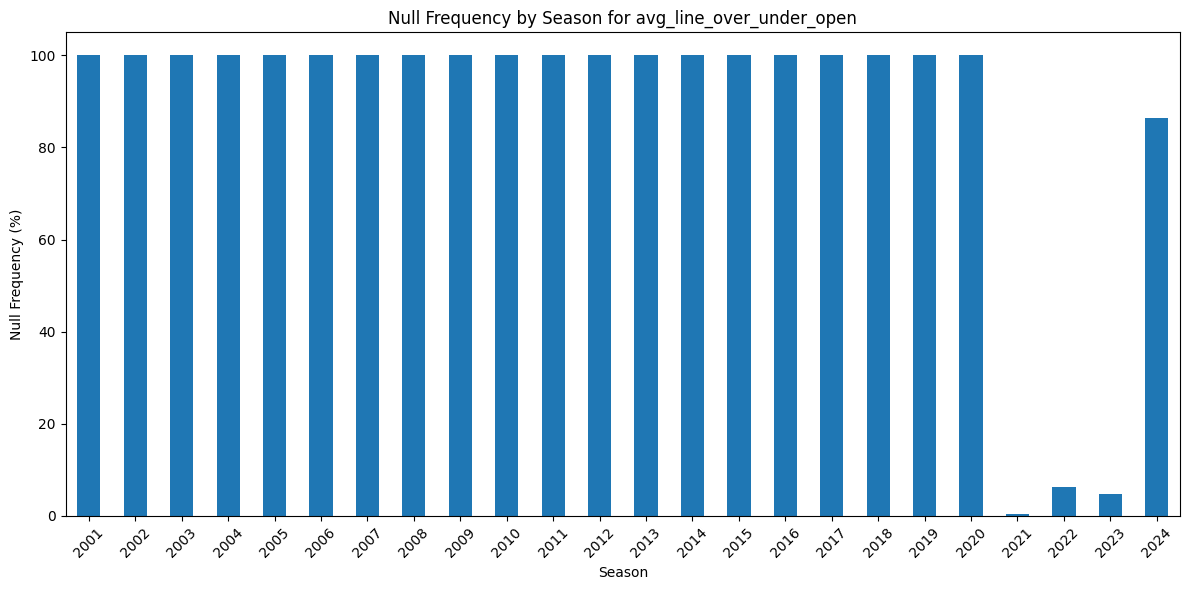

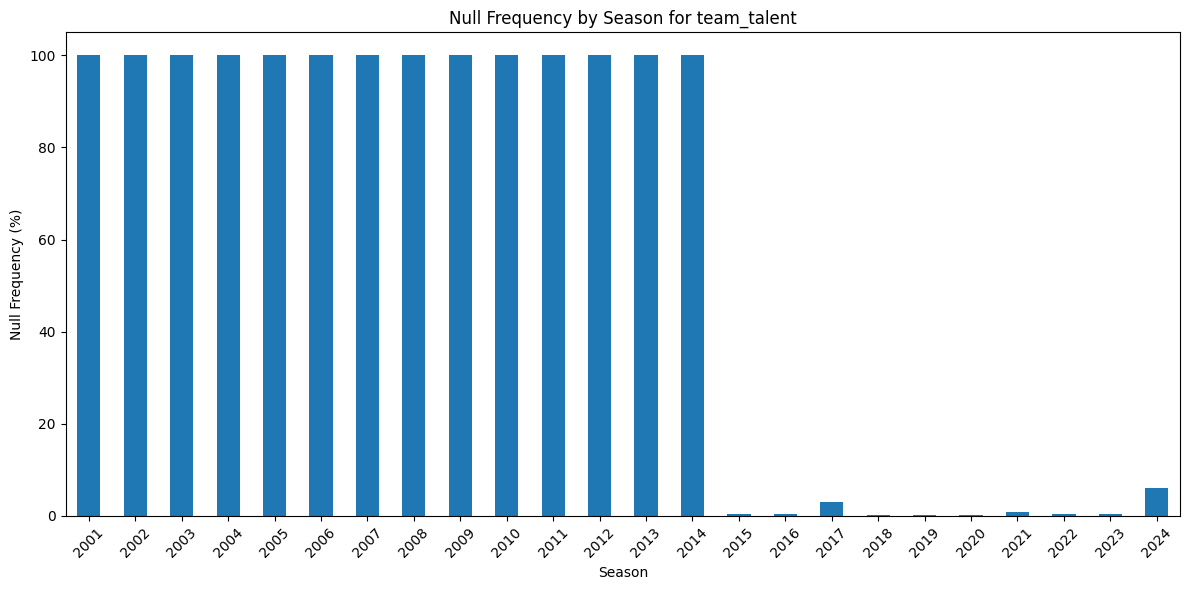

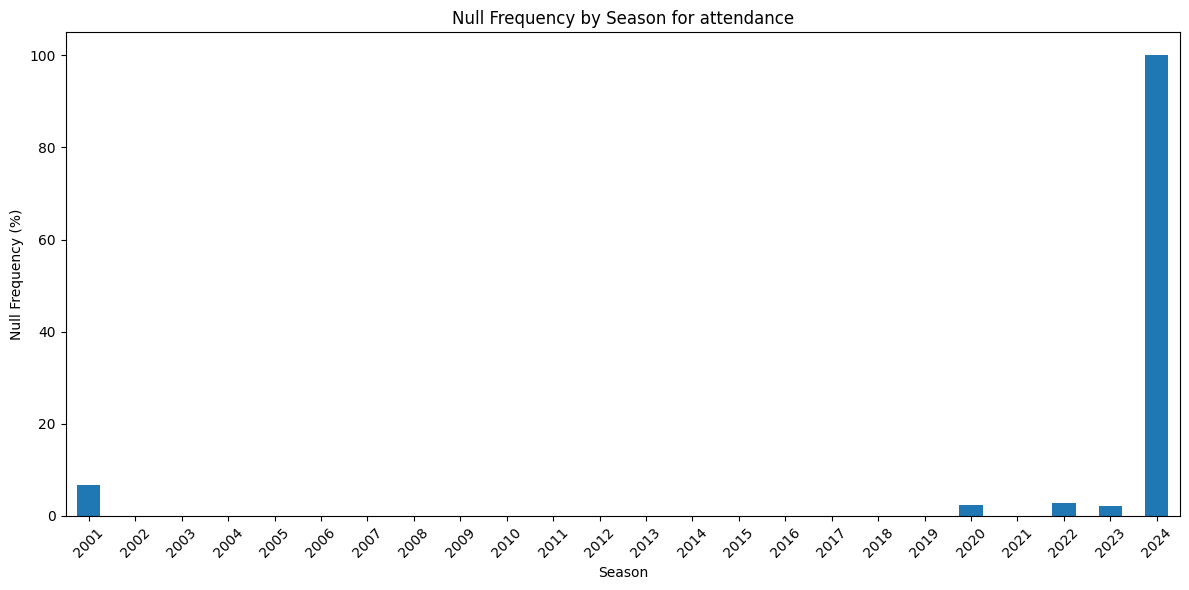

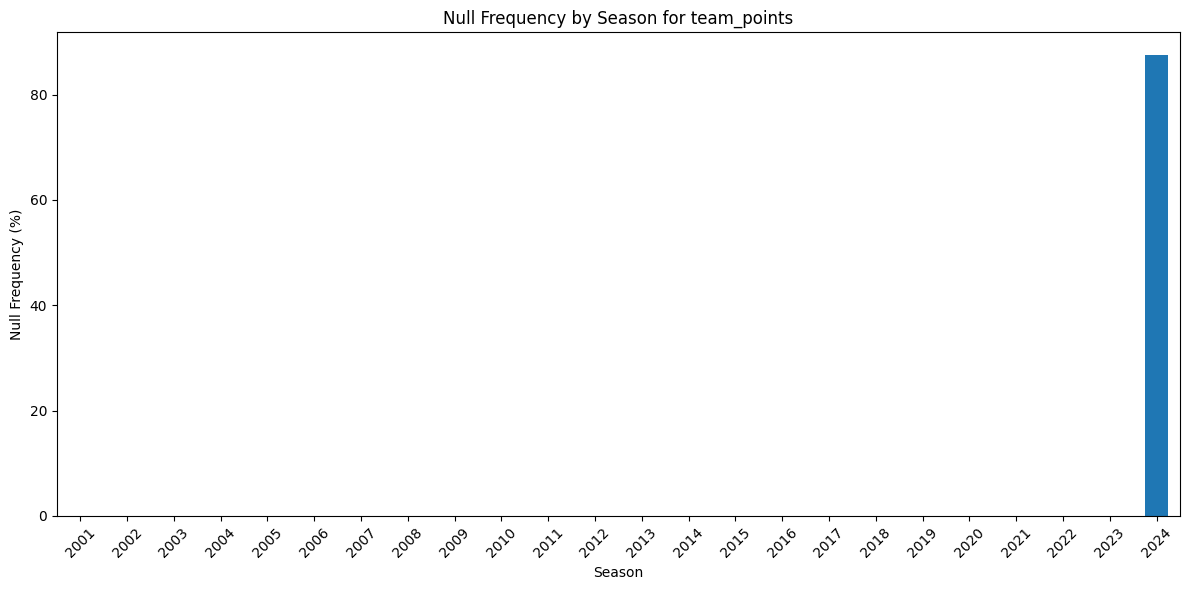

In [173]:
plot_null_frequency_by_season(transformed_teams_df, [
    'kickReturnTDs',
    'interceptions',
    'offense_passing_plays_ppa',
    'team_id',
    'rushingTDs',
    'excitement_index',
    'avg_line_spread',
    'team_pregame_win_prob',
    'avg_line_opponent_moneyline',
    'avg_line_over_under_open',
    'team_talent',
    'attendance',
    'team_points'
])

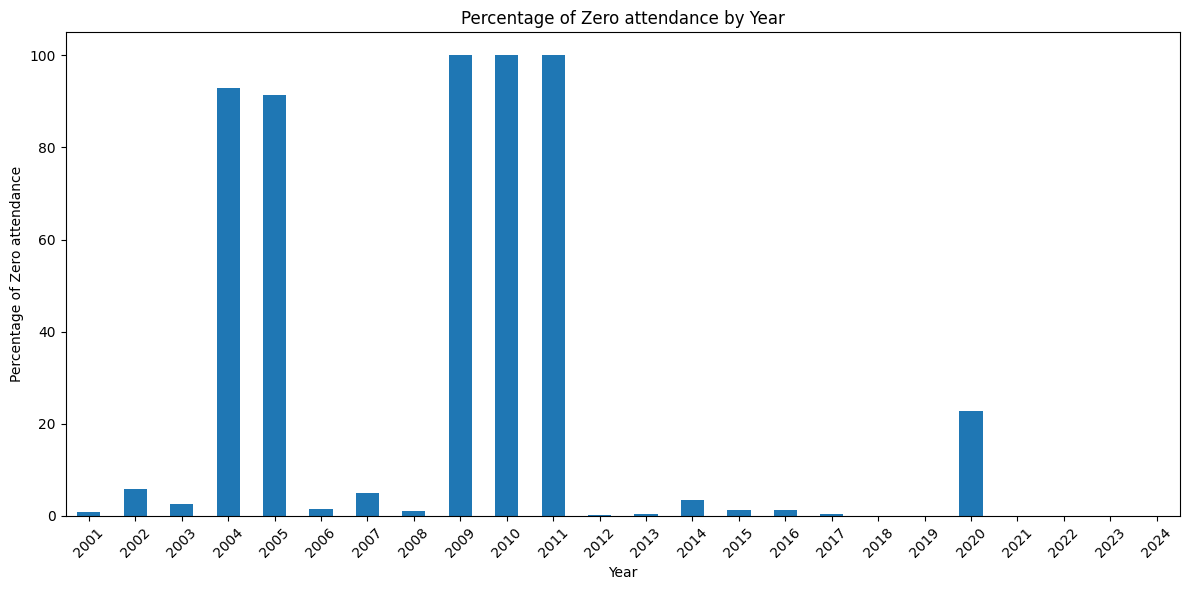

In [54]:
plot_zero_values_by_year(transformed_teams_df, 'attendance')

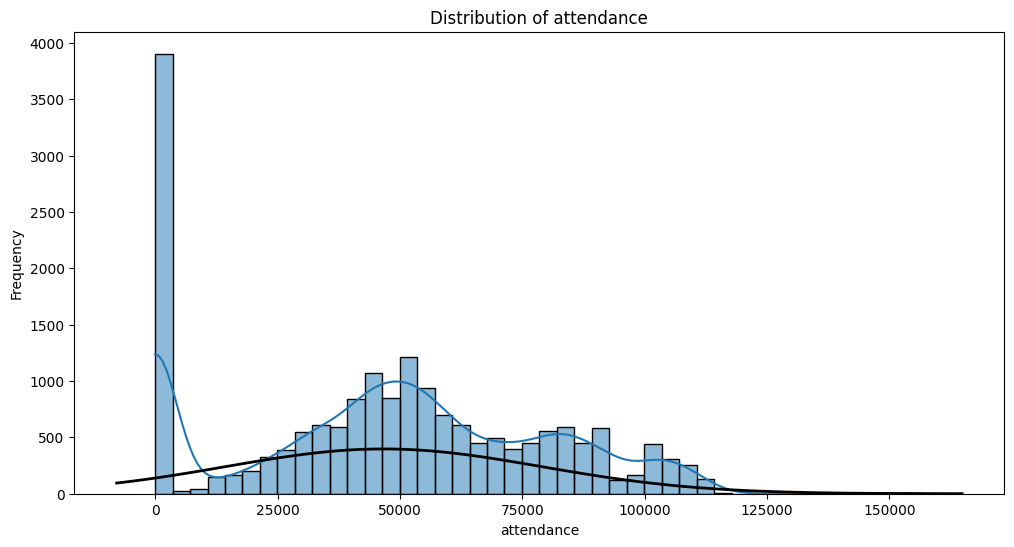

Shapiro-Wilk test - statistic: 0.9423, p-value: 0.0000
Skewness: 0.0227
Kurtosis: -0.9192


/Users/colingaffney/repos/personal-projects/college_football_predictor/venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 18564.
  res = hypotest_fun_out(*samples, **kwds)


In [30]:
analyze_distribution(df, 'attendance')

## Process Teams DB

In [13]:
from src.data.create_processed_teams import create_processed_teams_db, load_processed_teams_df

# Define the paths (adjust these as needed for your notebook's location)
source_db_path = '../data/02_interim/transformed_teams.db'
target_db_path = '../data/03_processed/processed_teams.db'

# Create the processed teams database
create_processed_teams_db(source_db_path, target_db_path)

# Load the processed teams data into a DataFrame
processed_teams_df = load_processed_teams_df(target_db_path)

# Now you can work with the processed_teams_df
print(processed_teams_df.shape)

Source DB path: ../data/02_interim/transformed_teams.db
Target DB path: ../data/03_processed/processed_teams.db
Processed teams data has been written to ../data/03_processed/processed_teams.db
(20750, 144)


In [14]:
import pandas as pd
import numpy as np

# Assuming 'year' column exists in processed_teams_df
# If not, you might need to extract it from 'start_date' or another relevant column

temp = processed_teams_df[processed_teams_df['year'] < 2024]

# Function to calculate null percentage for a column in a given year
def null_percentage(df, column, year):
    year_data = df[df['year'] == year][column]
    return (year_data.isnull().sum() / len(year_data)) * 100 if not year_data.empty else np.nan

# Get all columns except 'year'
columns = [col for col in temp.columns if col != 'year']

# Get unique years
years = temp['year'].unique()

# Calculate null percentages for each column and year
null_percentages = {col: {year: null_percentage(temp, col, year) for year in years} for col in columns}

# Convert to DataFrame for easier analysis
null_df = pd.DataFrame(null_percentages)

# Function to find years with non-null values for each column
def years_with_non_nulls(series):
    return [year for year, value in series.items() if not pd.isnull(value) and value < 100]

# Calculate highest null percentage for each column in years with non-nulls
highest_nulls = {}
for col in null_df.columns:
    non_null_years = years_with_non_nulls(null_df[col])
    if non_null_years:
        highest_null = null_df.loc[non_null_years, col].max()
        highest_nulls[col] = highest_null

# Sort columns by highest null percentage
sorted_columns = sorted(highest_nulls.items(), key=lambda x: x[1], reverse=True)

# Print results
print("Columns with highest % of nulls in years where they have non-nulls:")
for col, percentage in sorted_columns:
    print(f"{col}: {percentage:.2f}%")


Columns with highest % of nulls in years where they have non-nulls:
kickReturnYards: 97.36%
kickReturnTDs: 97.36%
kickReturns: 97.36%
offense_open_field_yards: 93.84%
offense_open_field_yards_total: 93.84%
defense_open_field_yards: 93.84%
defense_open_field_yards_total: 93.84%
offense_plays: 93.15%
offense_drives: 93.15%
offense_ppa: 93.15%
offense_total_ppa: 93.15%
offense_success_rate: 93.15%
offense_explosiveness: 93.15%
offense_power_success: 93.15%
offense_stuff_rate: 93.15%
offense_line_yards: 93.15%
offense_line_yards_total: 93.15%
offense_second_level_yards: 93.15%
offense_second_level_yards_total: 93.15%
offense_standard_downs_ppa: 93.15%
offense_standard_downs_success_rate: 93.15%
offense_standard_downs_explosiveness: 93.15%
offense_passing_downs_ppa: 93.15%
offense_passing_downs_success_rate: 93.15%
offense_passing_downs_explosiveness: 93.15%
offense_rushing_plays_ppa: 93.15%
offense_rushing_plays_total_ppa: 93.15%
offense_rushing_plays_success_rate: 93.15%
offense_rushing_p

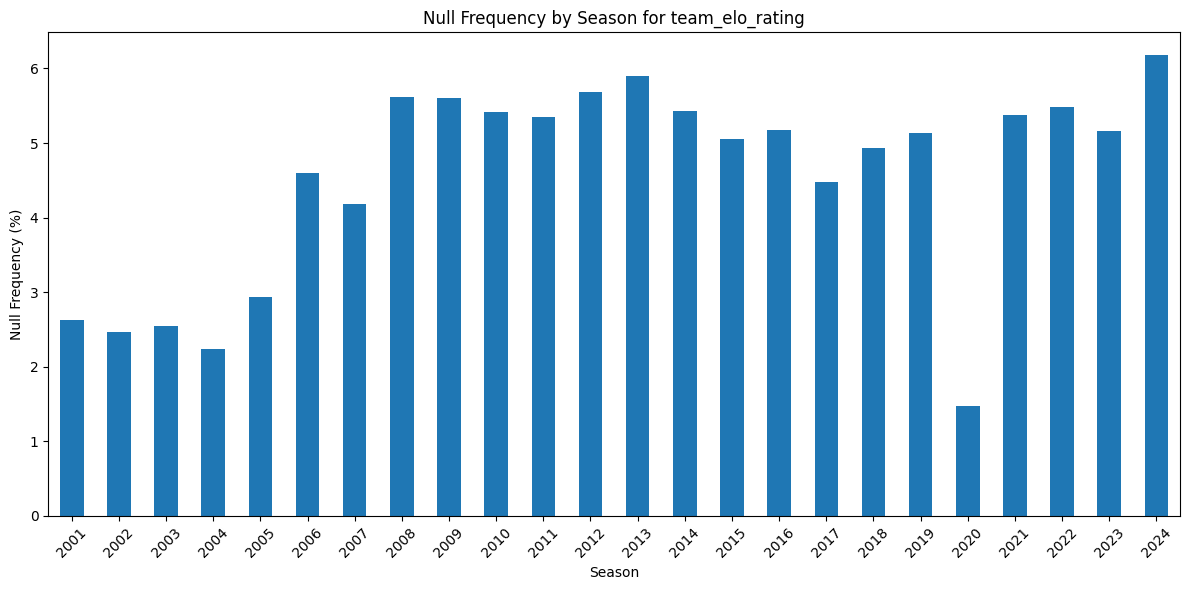

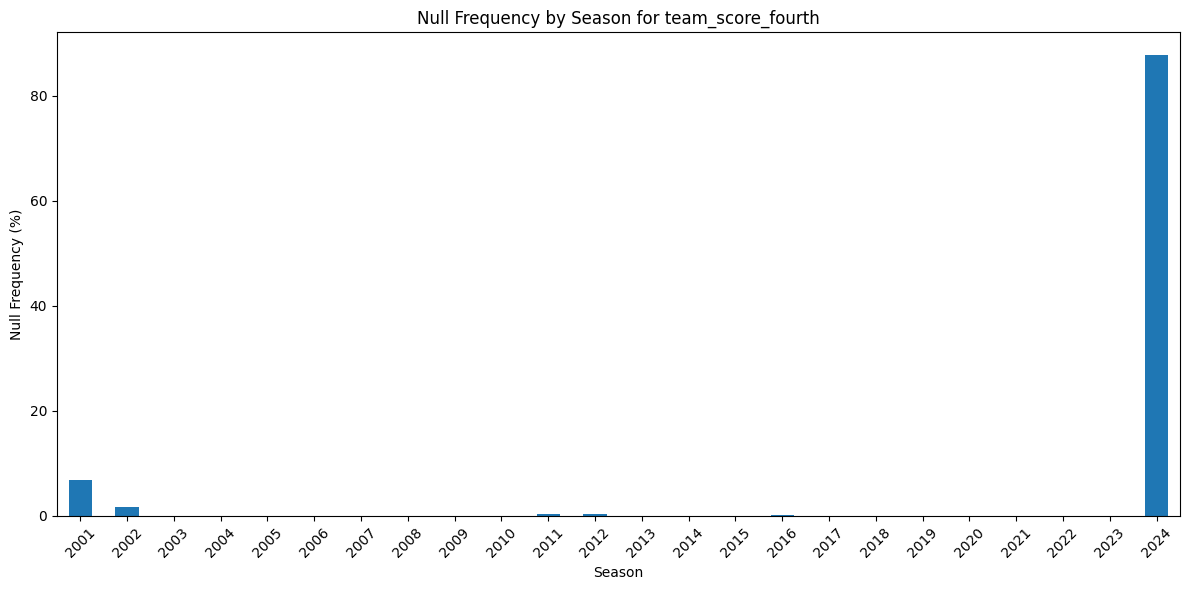

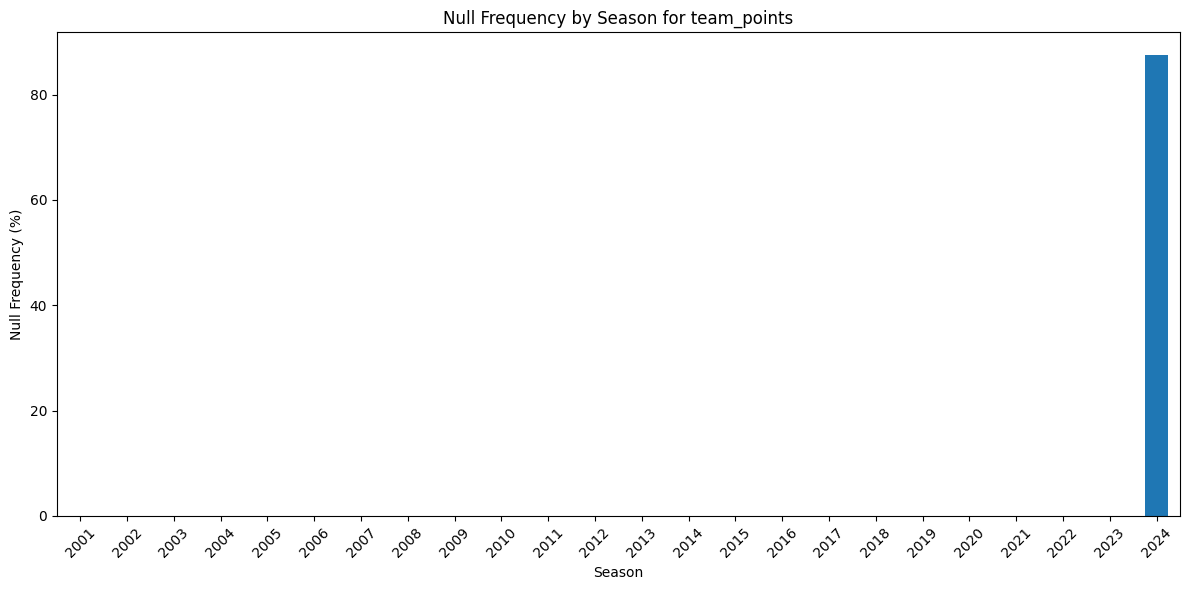

In [165]:
plot_null_frequency_by_season(processed_teams_df, ['team_elo_rating', 'team_score_fourth', 'team_points'])

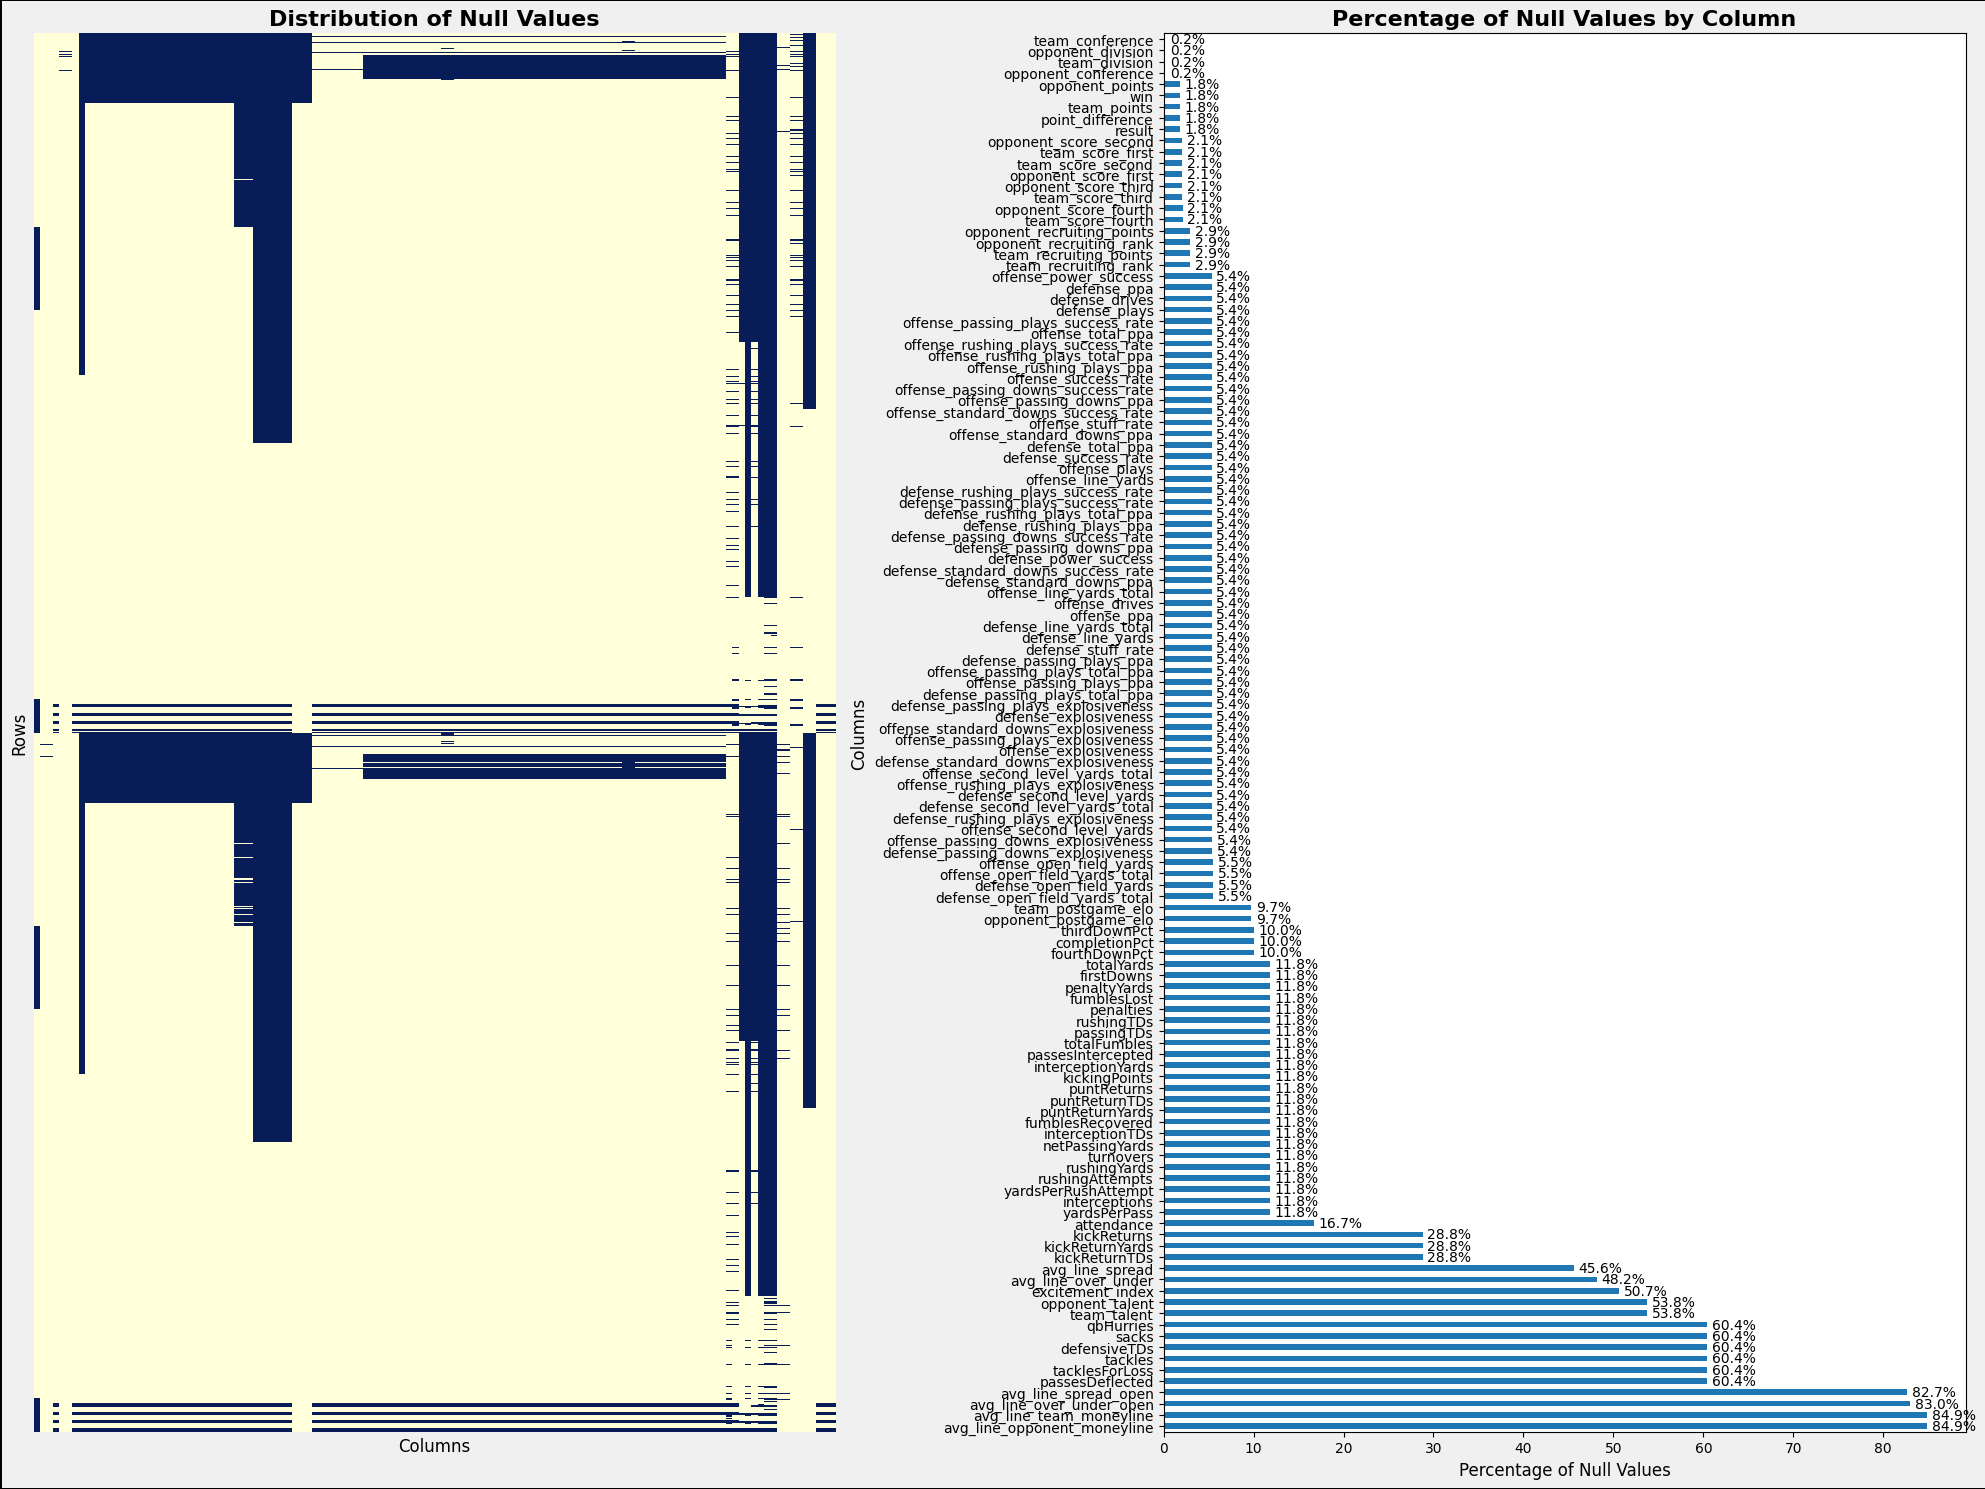

Columns with null values (sorted by percentage, descending):
avg_line_opponent_moneyline: 17619 null values (84.91%)
avg_line_team_moneyline: 17619 null values (84.91%)
avg_line_over_under_open: 17218 null values (82.98%)
avg_line_spread_open: 17152 null values (82.66%)
passesDeflected: 12536 null values (60.41%)
tacklesForLoss: 12536 null values (60.41%)
tackles: 12536 null values (60.41%)
defensiveTDs: 12536 null values (60.41%)
sacks: 12536 null values (60.41%)
qbHurries: 12536 null values (60.41%)
team_talent: 11154 null values (53.75%)
opponent_talent: 11154 null values (53.75%)
excitement_index: 10514 null values (50.67%)
avg_line_over_under: 9998 null values (48.18%)
avg_line_spread: 9464 null values (45.61%)
kickReturnTDs: 5983 null values (28.83%)
kickReturnYards: 5983 null values (28.83%)
kickReturns: 5983 null values (28.83%)
attendance: 3464 null values (16.69%)
yardsPerPass: 2454 null values (11.83%)
interceptions: 2454 null values (11.83%)
yardsPerRushAttempt: 2454 null v

In [15]:
visualize_null_values(processed_teams_df)

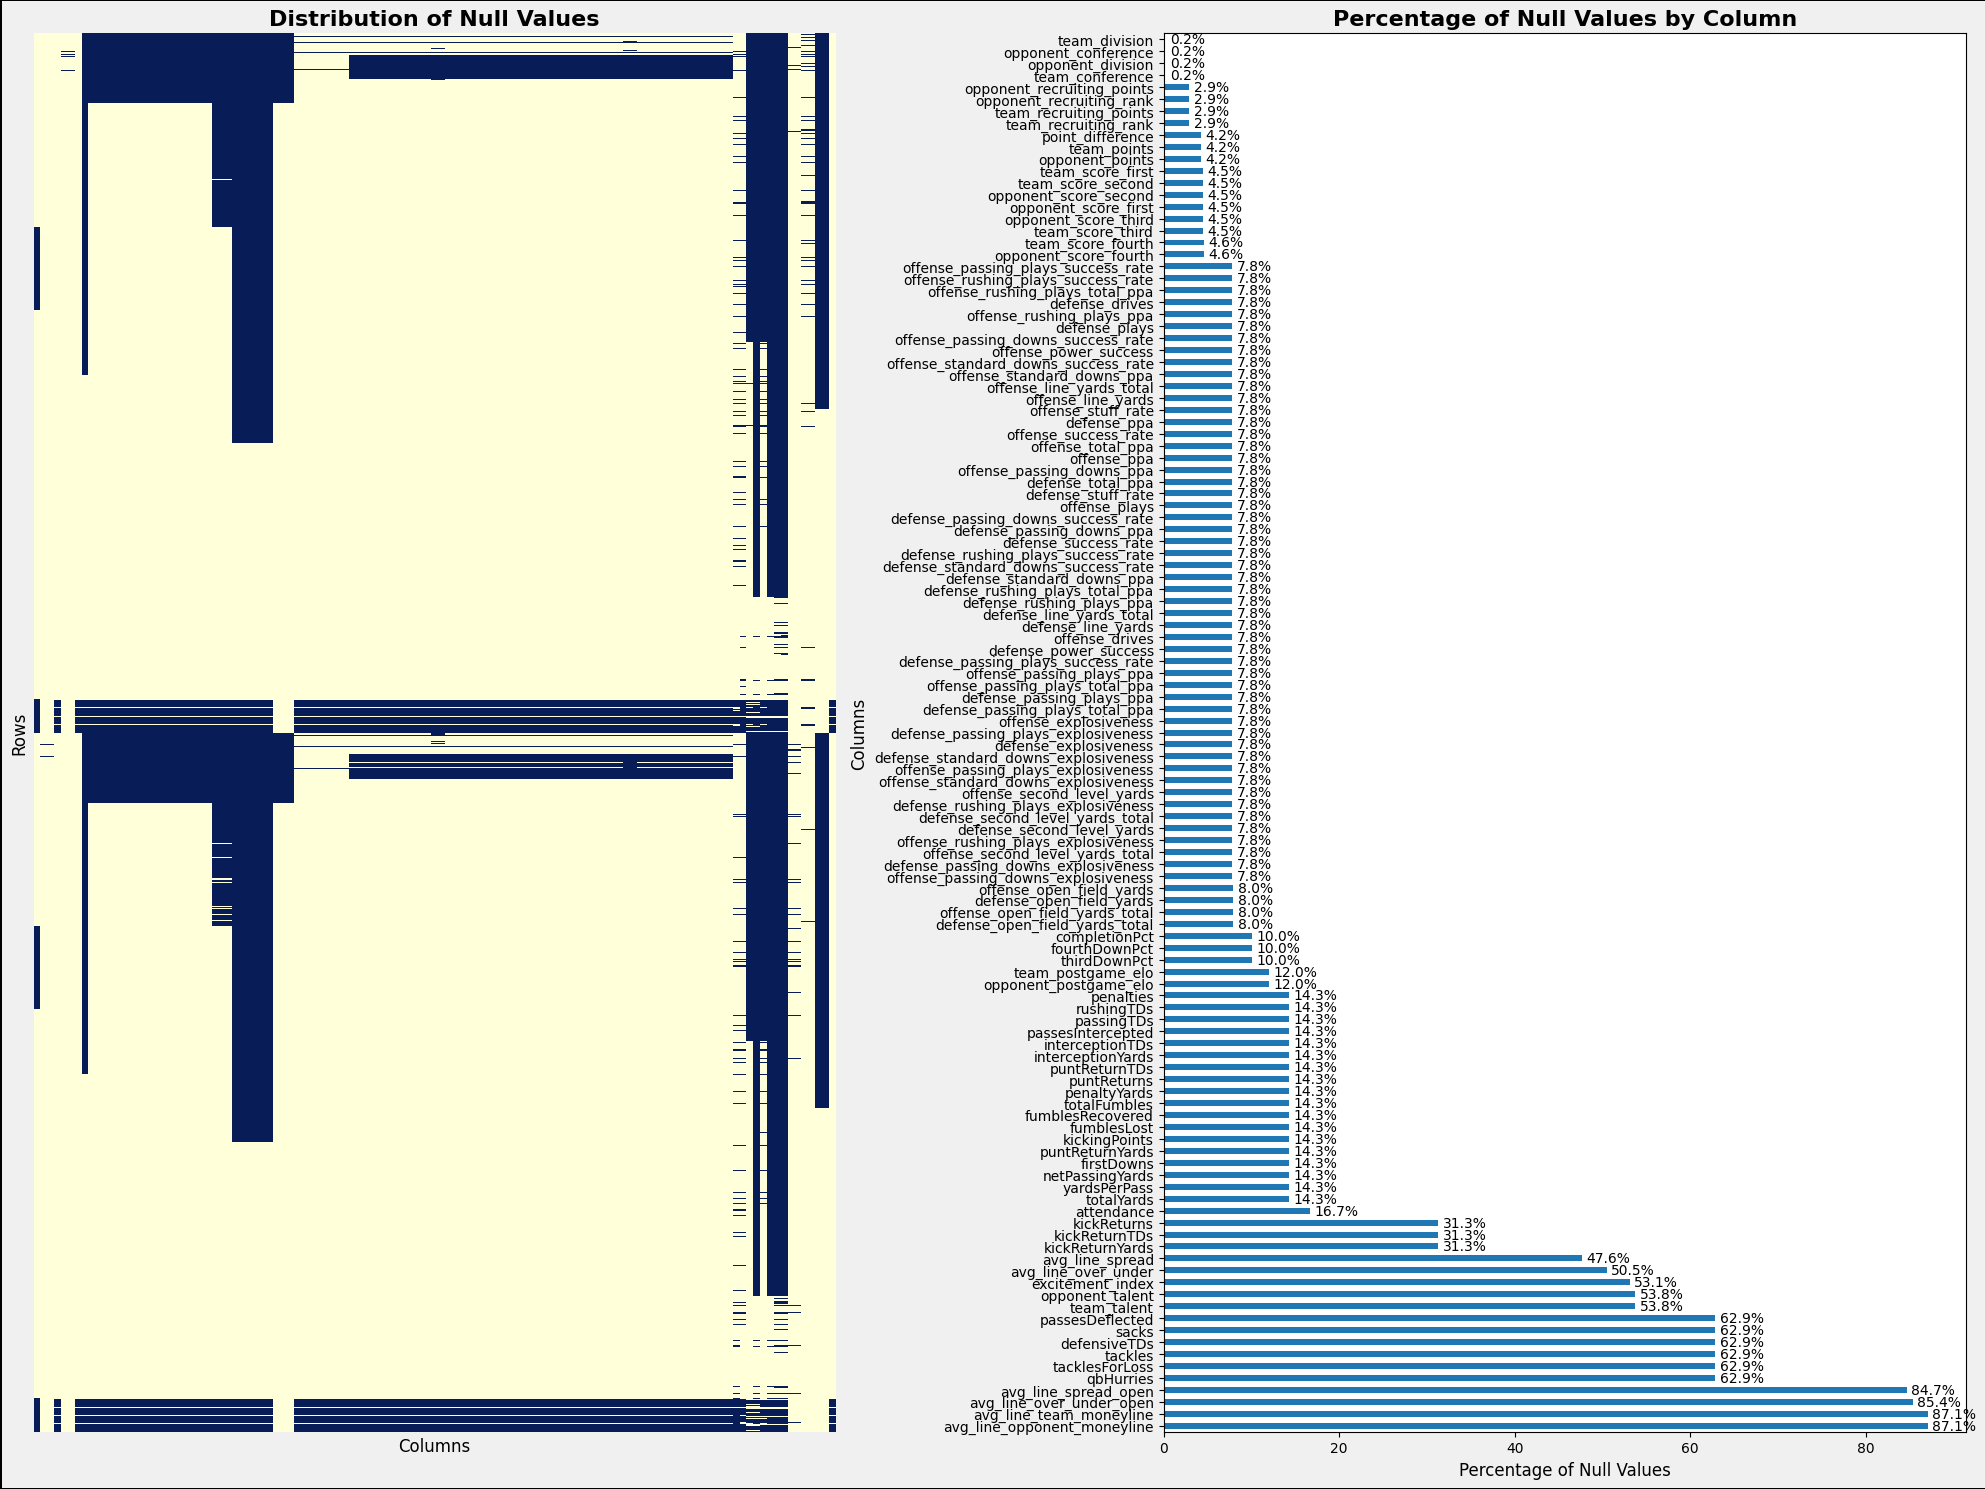

Columns with null values (sorted by percentage, descending):
avg_line_opponent_moneyline: 18063 null values (87.05%)
avg_line_team_moneyline: 18063 null values (87.05%)
avg_line_over_under_open: 17712 null values (85.36%)
avg_line_spread_open: 17572 null values (84.68%)
qbHurries: 13042 null values (62.85%)
tacklesForLoss: 13042 null values (62.85%)
tackles: 13042 null values (62.85%)
defensiveTDs: 13042 null values (62.85%)
sacks: 13042 null values (62.85%)
passesDeflected: 13042 null values (62.85%)
team_talent: 11154 null values (53.75%)
opponent_talent: 11154 null values (53.75%)
excitement_index: 11020 null values (53.11%)
avg_line_over_under: 10474 null values (50.48%)
avg_line_spread: 9884 null values (47.63%)
kickReturnYards: 6491 null values (31.28%)
kickReturnTDs: 6491 null values (31.28%)
kickReturns: 6491 null values (31.28%)
attendance: 3464 null values (16.69%)
totalYards: 2960 null values (14.27%)
yardsPerPass: 2960 null values (14.27%)
netPassingYards: 2960 null values 

In [169]:
visualize_null_values(processed_teams_df)

## Appendix: Split into All Years and All Data

In [173]:
# Split cleaned_df into two DataFrames

# DataFrame with seasons 2016 and later
df_2016_plus = cleaned_df[cleaned_df['season'] >= 2016].copy()

# DataFrame with all seasons but specific columns dropped
columns_to_drop = [
    'tacklesForLoss', 'defensiveTDs', 'tackles', 'sacks', 'qbHurries',
    'passesDeflected', 'team_talent', 'opponent_talent', 'excitement_index',
    'kickReturnYards', 'kickReturnTDs', 'kickReturns', 'attendance'
]
df_all_years = cleaned_df.drop(columns=columns_to_drop)

# Print info about the resulting DataFrames
print("DataFrame with seasons 2016 and later:")
print(f"Shape: {df_2016_plus.shape}")
print(f"Seasons included: {df_2016_plus['season'].unique()}")
print("\nDataFrame with all seasons and specific columns dropped:")
print(f"Shape: {df_all_years.shape}")
print(f"Seasons included: {df_all_years['season'].unique()}")
print("Columns dropped:", columns_to_drop)

# Verify that the specified columns were dropped
remaining_columns = set(df_all_years.columns)
dropped_columns = set(columns_to_drop)
if not dropped_columns.issubset(cleaned_df.columns):
    print("\nWarning: Some specified columns were not in the original DataFrame.")
if dropped_columns.intersection(remaining_columns):
    print("\nWarning: Some specified columns were not dropped.")
else:
    print("\nAll specified columns were successfully dropped from df_all_years.")

DataFrame with seasons 2016 and later:
Shape: (7110, 121)
Seasons included: [2016 2017 2018 2019 2020 2021 2022 2023]

DataFrame with all seasons and specific columns dropped:
Shape: (16438, 108)
Seasons included: [2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023]
Columns dropped: ['tacklesForLoss', 'defensiveTDs', 'tackles', 'sacks', 'qbHurries', 'passesDeflected', 'team_talent', 'opponent_talent', 'excitement_index', 'kickReturnYards', 'kickReturnTDs', 'kickReturns', 'attendance']

All specified columns were successfully dropped from df_all_years.
